Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0807 - val_loss: 0.0460
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0454 - val_loss: 0.0429
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0429 - val_loss: 0.0415
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0415 - val_loss: 0.0408
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0409 - val_loss: 0.0404
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0404 - val_loss: 0.0398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


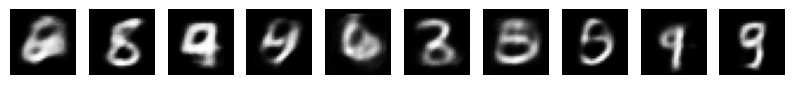

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling function for the reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        tf.random.set_seed(None)  # Change seed every time the VAE is called
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

# Define the encoder
latent_dim = 10

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(400, activation="relu")(x)
mu = layers.Dense(latent_dim)(x)
logvar = layers.Dense(latent_dim)(x)
z = Sampling()([mu, logvar])
encoder = keras.Model(encoder_inputs, [z, mu, logvar], name="encoder")

# Define the decoder
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(400, activation="relu")(decoder_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

# Define the VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*0.00
        self.add_loss(kl_loss)
        return reconstructed

# Instantiate the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss="mse")

# Load the MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Train the VAE model
vae.fit(x_train, x_train, epochs=6, batch_size=128, validation_data=(x_test, x_test), verbose=True)

# Generate new samples from the latent space
num_samples = 10
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

plt.figure(figsize=(10, 1))
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


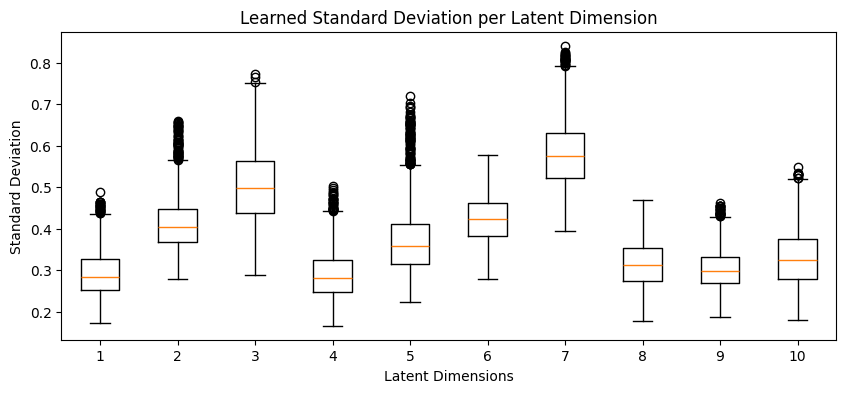

In [39]:
# Extract and visualize the learned standard deviation
def visualize_std(encoder, data):
    _, _, logvar = encoder.predict(data)
    std = np.exp(0.5 * logvar)  # Convert log variance to standard deviation

    plt.figure(figsize=(10, 4))
    plt.boxplot(std)
    plt.xlabel("Latent Dimensions")
    plt.ylabel("Standard Deviation")
    plt.title("Learned Standard Deviation per Latent Dimension")
    plt.show()

# Visualize using a subset of the test data
visualize_std(encoder, x_test[:1000])
